In [30]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from pyscf.grad import RHF as g
import inspect
import sys
sys.path.append("../Libs")
from FcMole import FcM,FcM_like
from FDcoeffs import get_coeffs
from ao_scf import ao_RHF
from numpy.linalg import norm

In [7]:
nn=gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]))
mf=scf.RHF(nn)
e_nn=mf.scf()

converged SCF energy = -107.491645836044


In [8]:
S_nn=mf.get_ovlp()
h1_nn=mf.get_hcore()
P_nn=mf.make_rdm1()
g_ijkl=nn.intor('int2e', aosym='s8')
C=mf.mo_coeff
O=mf.mo_occ
e=mf.mo_energy

In [9]:
cn=gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]),charge=-1)
on=gto.M(atom="O 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]),charge=1)

In [10]:
mf_on=scf.RHF(on)
mf_cn=scf.RHF(cn)
e_on=mf_on.scf()
e_cn=mf_cn.scf()
S_on=mf_on.get_ovlp()
S_cn=mf_cn.get_ovlp()

converged SCF energy = -127.196060151265
converged SCF energy = -90.9175998689459


In [11]:
dS=(S_on-S_cn)/2
dh1=(mf_on.get_hcore()-mf_cn.get_hcore())/2
dG=(on.intor('int2e', aosym='s8')-cn.intor('int2e', aosym='s8'))/2
dVnn=(8*7-7*7)/2.05
d2S=(mf_on.get_ovlp()+mf_cn.get_ovlp()-2*mf.get_ovlp())
d2h1=(mf_on.get_hcore()+mf_cn.get_hcore()-2*mf.get_hcore())
d2G=(on.intor('int2e', aosym='s8')+cn.intor('int2e', aosym='s8')-2*nn.intor('int2e', aosym='s8'))

In [12]:
def E(l):
    return ao_RHF(FcM_like(nn,fcs=[l,0]),S_ao=S_nn+dS*l+d2S*l**2/2,hcore=h1_nn+dh1*l+d2h1*l**2/2,\
                  eri=g_ijkl+dG*l+d2G*l**2/2).scf()
def P(l):
    mf=ao_RHF(FcM_like(nn,fcs=[l,0]),S_ao=S_nn+dS*l+d2S*l**2/2,hcore=h1_nn+dh1*l+d2h1*l**2/2,\
                  eri=g_ijkl+dG*l+d2G*l**2/2)
    mf.scf()
    return mf.make_rdm1()

In [15]:
P_nn=mf.make_rdm1()
P_on=mf_on.make_rdm1()
P_cn=mf_cn.make_rdm1()
S_on=mf_on.get_ovlp()
dP_fd=(P(.1)-P(-.1))/.2
dP_fd2=(P(.1)+P(-.1)-2*P_nn)/.1**2

converged SCF energy = -109.316158807033
converged SCF energy = -105.698562338292
converged SCF energy = -109.316158807033
converged SCF energy = -105.698562338292


# CPHF calc

In [20]:
from pyscf.scf import cphf
import pyscf.qmmm
from pyscf import gto, scf
import numpy as np
from pyscf import lib
from functools import reduce
from pyscf.scf import cphf
from pyscf import lib
from pyscf.prop.nmr import rhf as rhf_nmr
from alch_deriv_NEW import DeltaV
def make_dP(mf,mo1):
    mol=mf.mol
    nao=mol.nao
    nocc=mf.mol.nelec[0]
    C=mf.mo_coeff
    dP=np.zeros_like(C)
    dP[:,:]=2*np.einsum('ij,jk,lk->il',C,mo1,C[:,:nocc])
    return dP+dP.T

def make_U(mo1):
    U=np.zeros((mo1.shape[0],mo1.shape[0]))
    U[:,:mo1.shape[1]]=mo1
    U=U-U.T
    return U

In [65]:
def alchemy_pol_deriv(polobj,int_r, with_cphf=True):
    mf = polobj._scf
    mol = mf.mol
    mo_energy = mf.mo_energy
    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    occidx = mo_occ > 0
    orbo = mo_coeff[:, occidx]
    orbv = mo_coeff[:,~occidx]
    charges = mol.atom_charges()
    coords  = mol.atom_coords()
    charge_center = np.einsum('i,ix->x', charges, coords)/ charges.sum()
    h1 = lib.einsum('xpq,pi,qj->xij', int_r, mo_coeff.conj(), orbo) #going to molecular orbitals?
    s1 = np.zeros_like(h1)
    vind = polobj.gen_vind(mf, mo_coeff, mo_occ)
    if with_cphf:
        mo1,e1 = cphf.solve(vind, mo_energy, mo_occ, h1, s1, polobj.max_cycle_cphf, polobj.conv_tol)
    else:
        mo1 = rhf_nmr._solve_mo1_uncoupled(mo_energy, mo_occ, h1, s1)[0]
        return mo1
    return mo1,e1

In [100]:
def alchemy_pol_deriv2(polobj,int_r, with_cphf=True):
    mf = polobj._scf
    mol = mf.mol
    mo_energy = mf.mo_energy
    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    occidx = mo_occ > 0
    orbo = mo_coeff[:, occidx]
    orbv = mo_coeff[:,~occidx]
    charges = mol.atom_charges()
    coords  = mol.atom_coords()
    charge_center = np.einsum('i,ix->x', charges, coords) / charges.sum()
    h1 = lib.einsum('xpq,pi,qj->xij', int_r, mo_coeff.conj(), orbo) #going to molecular orbitals?
    s1 = lib.einsum('xpq,pi,qj->xij', [dS], mo_coeff.conj(), orbo) # np.asarray([dS[:, occidx]])
    vind = polobj.gen_vind(mf, mo_coeff, mo_occ)
    mo1,e1 = cphf.solve(vind, mo_energy, mo_occ, h1,s1, polobj.max_cycle_cphf, polobj.conv_tol)
    return mo1,e1

In [48]:
mol=nn
dL=[[0],[1]]
polobj=mf.Polarizability()
int_r=DeltaV(mol,dL)    
mo1,e1=alchemy_pol_deriv(polobj,int_r)
mo1,e1=alchemy_pol_deriv(polobj,[dh1])
nao=mol.nao
nocc=mol.nelectron//2 #RHF
U=np.zeros((nao,nao))
U[:,:nocc]=mo1[0,:,:nocc]
U=U-U.T
O=np.diag(mf.mo_occ)
C=mf.mo_coeff
dP=C@(U@O-O@U)@C.T    

In [67]:
norm(P_nn+dP_fd-P_on),norm(P_nn+dP-P_on),norm(P_nn-P_on)

(0.17042041102800312, 7.274404627782336, 0.6139641971704994)

(8.063571172490876, 7.149418874588267, 2.081439058143301)

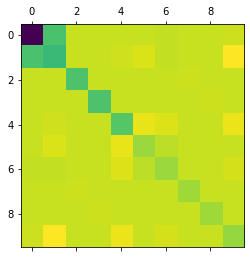

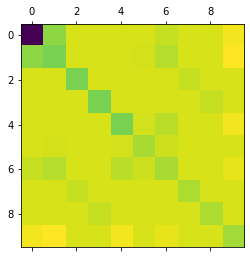

In [68]:
plt.matshow(dh1),plt.matshow(int_r[0])
norm(dh1),norm(int_r),norm(dh1-int_r)

In [125]:
dh1.diagonal(),int_r[0].diagonal()

(array([-6.92681786, -1.80247531, -1.46949462, -1.46949462, -1.34586125,
        -0.48780488, -0.48061857, -0.44273505, -0.44273505, -0.55544402]),
 array([-6.59799482, -0.9806245 , -0.97277427, -0.97277427, -0.97277427,
        -0.48780488, -0.48061857, -0.44273505, -0.44273505, -0.55544402]))

In [69]:
int_r.shape

(1, 10, 10)

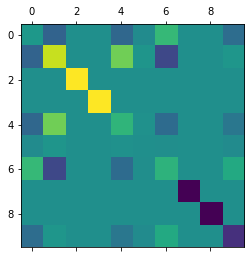

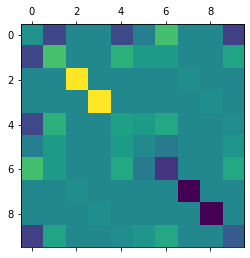

In [130]:
mo1,e1=alchemy_pol_deriv(polobj,int_r)
plt.matshow(make_dP(mf,mo1[0]))
dP2=make_dP(mf,mo1[0])
mo1,e1=alchemy_pol_deriv2(polobj,int_r)
plt.matshow(make_dP(mf,mo1[0]))
dP3=make_dP(mf,mo1[0])
norm(P_nn+dP2-P_on),norm(P_nn+dP3-P_on),norm(P_nn-P_on)

(7.274404627781862, 6.681706078537978, 0.6139641971704994)

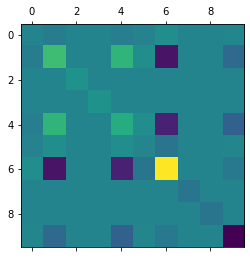

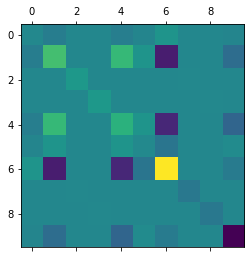

In [134]:
mo1,e1=alchemy_pol_deriv(polobj,[dh1])
plt.matshow(make_dP(mf,mo1[0]))
dP2=make_dP(mf,mo1[0])
mo1,e1=alchemy_pol_deriv2(polobj,[dh1])
plt.matshow(make_dP(mf,mo1[0]))
dP3=make_dP(mf,mo1[0])
norm(P_nn+dP2-P_on),norm(P_nn+dP3-P_on),norm(P_nn-P_on)

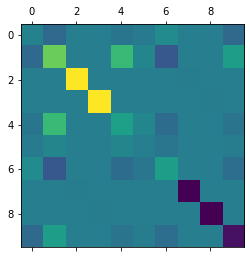

In [119]:
plt.matshow(P_on-P_nn)

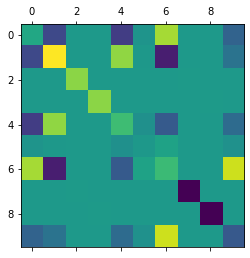

In [120]:
plt.matshow(make_dP(mf,mo1[0])-(P_on-P_nn))